# Notebook IV - PCA Visualisations
Laurine Dargaud, June 2022 (Biometric Systems, DTU course)

**Topic: Face Morphing Attack Detection**

In [72]:
_EXPERIMENT_NUMBER_ = '68'

# training set parameters
_DATABASE_TRAIN_ = 'FRGCsub'
_MORPHING_ALGO_TRAIN_ = 'facefusion'

# test set parameters
_DATABASE_TEST_ = 'FRGCsub'
_MORPHING_ALGO_TEST_ = 'facefusion'

# size of images
_IMAGE_WIDTH_ = _IMAGE_HEIGHT_ = 500
print('Width x Height =', _IMAGE_WIDTH_, 'x', _IMAGE_HEIGHT_)

# number of components for pca
_NB_COMPONENTS_ = 20

## Global Imports, Methods & Definitions

In [73]:
from os import listdir
from os.path import isfile, join

import cv2
from sklearn.decomposition import PCA
import numpy as np

from joblib import dump, load

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def process_image(anImage):
    return cv2.cvtColor(anImage, cv2.COLOR_BGR2GRAY)

def get_data_matrix(aXfilenames, H = _IMAGE_HEIGHT_, W = _IMAGE_WIDTH_):
    # get the number of pictures in the training set
    N = len(aXfilenames)

    # get height and width of image
    M = H*W

    # create N*M data matrix of zeros
    data = np.zeros((M,N))

    # fill the empty matrix so that each column is one face image
    for k in range (N):
        # read image
        img = cv2.imread(aXfilenames[k])
        # resize
        if img.shape[:2] != (W,H):
            img = cv2.resize(img, (W,H))
        # process image
        img = process_image(img)
        # reshape
        tt = np.reshape(img, M)
        # fill data matrix
        data[:,k] = tt

    X = data.T
    return X

def change_color_channel_in_path(aPath, aColorChannel):
    result = aPath.split('/')
    result[-2] = result[-2]+f'-lpb-{aColorChannel}comp-cropped'
    return '/'.join(result)

_EXPERIMENT_PATH_ = f'data/S-MAD-Experiments/{_EXPERIMENT_NUMBER_}/'
print(_EXPERIMENT_PATH_)

all_files_in_exp_repo = [f for f in listdir(_EXPERIMENT_PATH_) if isfile(join(_EXPERIMENT_PATH_, f))]

# load txt files from experiment
with open(_EXPERIMENT_PATH_+'X_filenames_train.txt') as f:
    X_filenames_train = f.readlines()[0]
    X_filenames_train = X_filenames_train.split(';')

with open(_EXPERIMENT_PATH_+'X_filenames_test.txt') as f:
    X_filenames_test = f.readlines()[0]
    X_filenames_test = X_filenames_test.split(';')
    
y_train = np.loadtxt(_EXPERIMENT_PATH_+'y_train.txt', delimiter=';')
y_test = np.loadtxt(_EXPERIMENT_PATH_+'y_test.txt', delimiter=';')

## Run & Save a PCA
To run only if PCA save files are not found in Experiment directory.
IT TAKES TIME!

In [ ]:
aColorChannel = 'B'

# generate path of color channel features repo
X_filenames_train_color = list(map(lambda p: change_color_channel_in_path(p, aColorChannel), X_filenames_train))
X_filenames_test_color = list(map(lambda p: change_color_channel_in_path(p, aColorChannel), X_filenames_test))
# run PCA
print(f'Running PCA for {aColorChannel}...')
X_train = get_data_matrix(X_filenames_train_color)
pca = PCA(_NB_COMPONENTS_).fit(X_train)
# project training set into PC space
print('  Projecting X_train into PC space...')
X_train_transformed = pca.transform(X_train)
# project test set into PC space
print('  Projecting X_test into PC space...')
X_test = get_data_matrix(X_filenames_test_color)
X_test_transformed = pca.transform(X_test)

# save PCA
dump(pca, _EXPERIMENT_PATH_+f'pca{aColorChannel}.joblib') 

## Load PCA joblib file

In [75]:
aColorChannel = 'B'
pca = load(_EXPERIMENT_PATH_+f'pca{aColorChannel}.joblib') 

X_train_transformed = np.loadtxt(_EXPERIMENT_PATH_+f'X_train_transformed_{aColorChannel}.txt', delimiter=';')
X_test_transformed = np.loadtxt(_EXPERIMENT_PATH_+f'X_test_transformed_{aColorChannel}.txt', delimiter=';')

## Visualisations

### Pairwise scatter plots visualization of PCs
Long to process...

In [ ]:
df_pairwise = pd.DataFrame(X_train_transformed)
df_pairwise.columns = [f'PC{a+1}' for a in range (_NB_COMPONENTS_)]
df_pairwise['isMorph']=y_train
sns.set(rc={'axes.facecolor':'w'})
sns.set_style("darkgrid")
pairplot = sns.pairplot(df_pairwise, hue='isMorph')
plt.show()

In [ ]:
# saving pairwise plot
pairplot.savefig(_EXPERIMENT_PATH_+f"pairplot_{aColorChannel}.png")

### Find the most discriminative components

In [77]:
# create dataframes
df_pairwise_train = pd.DataFrame(X_train_transformed)
df_pairwise_train.columns = [f'PC{a+1}' for a in range (_NB_COMPONENTS_)]
df_pairwise_train['isMorph']=y_train.astype(int)
df_pairwise_train['dataset'] = 'train'

df_pairwise_test = pd.DataFrame(X_test_transformed)
df_pairwise_test.columns = [f'PC{a+1}' for a in range (_NB_COMPONENTS_)]
df_pairwise_test['isMorph']=y_test.astype(int)
df_pairwise_test['dataset']='test'

df_pairwise = pd.concat([df_pairwise_train, df_pairwise_test])
df_pairwise = df_pairwise.reset_index()

In [78]:
# most discriminative components for TRAINING SET
discriminative_distance = {}
for i in range (_NB_COMPONENTS_):
    means = df_pairwise_train[[f'PC{i+1}','isMorph']].groupby('isMorph').mean().values.flatten()
    distance = abs(max(means)-min(means))
    discriminative_distance[i+1]=distance
# sort
discriminative_distance = list(sorted(discriminative_distance.items(), reverse=True, key = lambda x:x[1]))
print('MOST BF/F DISCRIMINATIVE COMPONENTS FOR TRAINING SET')
for pcNumber, distance in discriminative_distance[:10]:
    print(f'  - PC{pcNumber} -> distance = {distance}')

MOST BF/F DISCRIMINATIVE COMPONENTS FOR TRAINING SET
  - PC2 -> distance = 4059.9801592171934
  - PC1 -> distance = 3964.464762628274
  - PC4 -> distance = 1109.7029509778831
  - PC6 -> distance = 813.4077639404131
  - PC15 -> distance = 538.3399298610359
  - PC7 -> distance = 519.758203756429
  - PC5 -> distance = 475.19311275735964
  - PC18 -> distance = 316.9809739107549
  - PC20 -> distance = 282.6821519223416
  - PC16 -> distance = 225.15479114298358


### One 2D scatter plot for 2 PCs

In [ ]:
# enter PC number (from 1 to NB_COMP)
PC_number_x, PC_number_y = 2,1

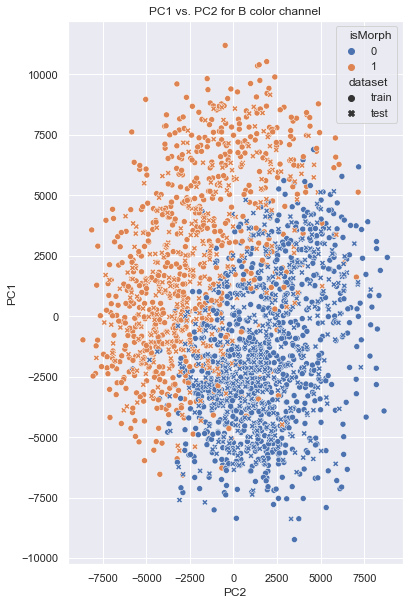

In [87]:
# 2D scatter plot
plt.figure(figsize=(6, 10))
sns.scatterplot(data=df_pairwise, x=f'PC{PC_number_x}', y=f'PC{PC_number_y}', hue="isMorph", style="dataset")
plt.title(f'PC{PC_number_y} vs. PC{PC_number_x} for {aColorChannel} color channel')
plt.savefig(_EXPERIMENT_PATH_+f"PC{PC_number_y} vs. PC{PC_number_x} for {aColorChannel} color channel.png")
plt.show()

### Density distributions

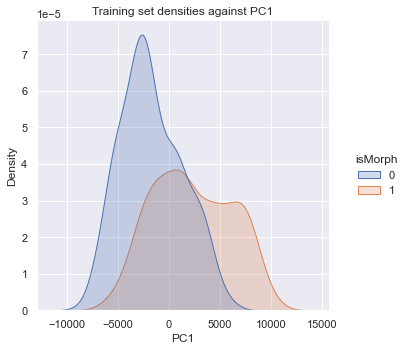

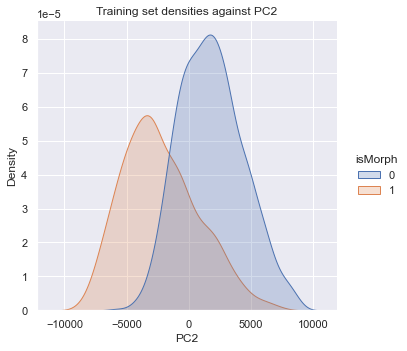

In [90]:
# plot density
sns.displot(df_pairwise_train, x=f'PC{PC_number_y}', hue="isMorph", kind="kde", fill=True)
plt.title(f'Training set densities against PC{PC_number_y}')
sns.displot(df_pairwise_train, x=f'PC{PC_number_x}', hue="isMorph", kind="kde", fill=True)
plt.title(f'Training set densities against PC{PC_number_x}')

#plt.savefig(_EXPERIMENT_PATH_+"Density distribution for Component {idx+1}.png")

plt.show()

### A PC as an image

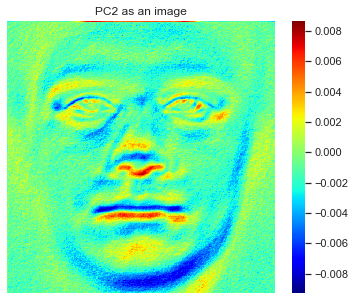

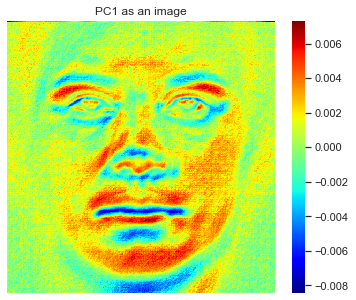

In [132]:
PC_toSee = PC_number_x
component = pca.components_[PC_toSee-1]
component = np.reshape(component,(_IMAGE_HEIGHT_,_IMAGE_WIDTH_))

plt.figure(figsize=(6,5))
sns.heatmap(component, cmap='jet')
plt.title(f'PC{PC_toSee} as an image')
plt.axis(False)
#plt.savefig(_EXPERIMENT_PATH_+f"PC{PC_toSee} - PCA in {symbol} for {_DATABASE_}.png")

PC_toSee = PC_number_y
component = pca.components_[PC_toSee-1]
component = np.reshape(component,(_IMAGE_HEIGHT_,_IMAGE_WIDTH_))

plt.figure(figsize=(6,5))
sns.heatmap(component, cmap='jet')
plt.title(f'PC{PC_toSee} as an image')
plt.axis(False)

plt.show()

### See the average LBP image of each class

In [103]:
# generate path of color channel features repo
X_filenames_train_color = list(map(lambda p: change_color_channel_in_path(p, aColorChannel), X_filenames_train))

In [111]:
bona_fide_training_set_images = get_data_matrix(np.array(X_filenames_train_color)[y_train==0])
morphs_training_set_images = get_data_matrix(np.array(X_filenames_train_color)[y_train==1])

In [127]:
bona_fide_avg = np.mean(bona_fide_training_set_images, axis=0) - pca.mean_
bona_fide_avg = np.reshape(bona_fide_avg,(_IMAGE_HEIGHT_,_IMAGE_WIDTH_))

morphs_avg = np.mean(morphs_training_set_images, axis=0) - pca.mean_
morphs_avg = np.reshape(morphs_avg,(_IMAGE_HEIGHT_,_IMAGE_WIDTH_))

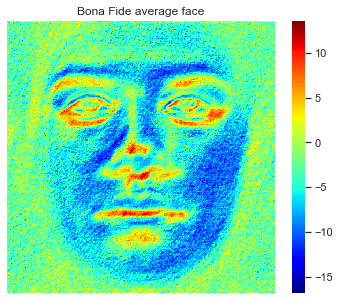

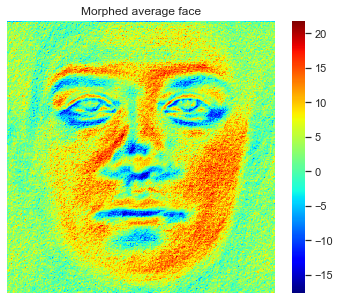

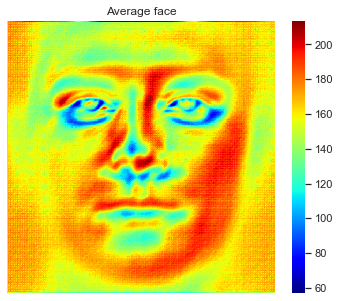

In [134]:
plt.figure(figsize=(6,5))
sns.heatmap(bona_fide_avg, cmap='jet')
plt.title(f'Bona Fide average face')
plt.axis(False)

plt.figure(figsize=(6,5))
sns.heatmap(morphs_avg, cmap='jet')
plt.title(f'Morphed average face')
plt.axis(False)

plt.figure(figsize=(6,5))
sns.heatmap(np.reshape(pca.mean_,(_IMAGE_HEIGHT_,_IMAGE_WIDTH_)), cmap='jet')
plt.title(f'Average face')
plt.axis(False)

plt.show()

### Variance explained

In [82]:
#threshold = 0.95
variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)

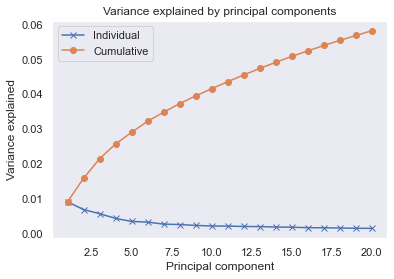

In [83]:
# Plot variance explained
plt.figure()
plt.plot(range(1,len(variance_ratio)+1),variance_ratio,'x-')
plt.plot(range(1,len(variance_ratio)+1),cumulative_variance_ratio,'o-')
#plt.plot([1,len(variance_ratio)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components');
plt.xlabel('Principal component');
plt.ylabel('Variance explained');
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()

In [88]:
variance_ratio*100

array([0.90150213, 0.67698116, 0.55915818, 0.42392765, 0.33668642,
       0.31674442, 0.25971883, 0.24681855, 0.22219167, 0.20609838,
       0.20207591, 0.19266799, 0.18816553, 0.17554065, 0.17063617,
       0.15802162, 0.15416641, 0.1472238 , 0.14044518, 0.13758873])

# THE END.